# Challenge 2

In [1]:
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")

## Load and explore the data

In [2]:
data = pd.read_csv('./Data/Cell_a.csv')
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
# Time in seconds
data['Arrival_Time'] = data.Arrival_Time.apply(lambda x: x/1_000_000) 
display(data)

,Job_ID,Task_ID,Arrival_Time,CPU,Memory,X
0,375000667413,0,6.030263e+02,0.041851,0.001169,0.418510
1,375000669289,0,6.064130e+02,0.024968,0.001179,0.249681
2,375000670586,0,6.089945e+02,0.024176,0.001173,0.241756
3,375000670588,0,6.089945e+02,0.019552,0.001163,0.195522
4,375000670590,0,6.090429e+02,0.028044,0.001179,0.280437
...,...,...,...,...,...,...
2329128,400465219425,0,2.678944e+06,0.000343,0.000004,0.003433
2329129,400465219425,1,2.678944e+06,0.000557,0.000004,0.005569
2329130,400465256347,0,2.678955e+06,0.002459,0.000050,0.024586
2329131,400465256349,0,2.678955e+06,0.004349,0.000052,0.043488


The first thing we want to know about the data is the time the jobs need to be executed.

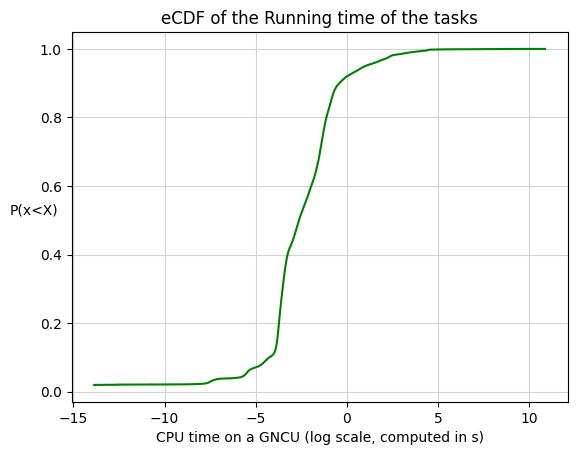

In [3]:
ecdf_X = ECDF(data.CPU)
plt.plot(np.log(ecdf_X.x), ecdf_X.y, color = 'green')
plt.xlabel('CPU time on a GNCU (log scale, computed in s)')
plt.ylabel('P(x<X)',rotation=0)
plt.title('eCDF of the Running time of the tasks')
plt.grid(which='major', color = 'lightgray')
plt.show()

From the plot we understand that most of the tasks need less than a second to be executed, in fact the eCDF at level $1$, $log(1) = 0$, is $0.92$.

The second quantity we would like to explore is amount of tasks that the jobs are composed of.

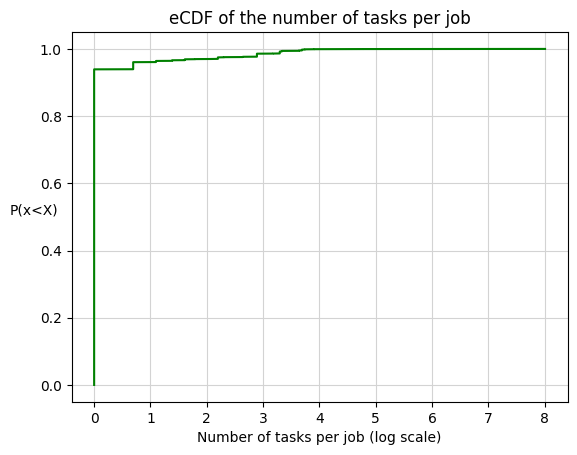

In [4]:
ecdf_Jobs = ECDF(data.groupby('Job_ID').size())
plt.plot(np.log(ecdf_Jobs.x), ecdf_Jobs.y, color = 'green')
plt.xlabel('Number of tasks per job (log scale)')
plt.ylabel('P(x<X)',rotation=0)
plt.title('eCDF of the number of tasks per job')
plt.grid(which='major', color = 'lightgray')
plt.show()

In this case we can see that most jobs are made of just a handfull of tasks. The ECDF value at level $1$, $log(1) = 0$, is, if fact $0.94$.

Another information we find is that the maximum numbers of task in a job is 2998.

We also would like to know about the size (in memory) of the tasks.

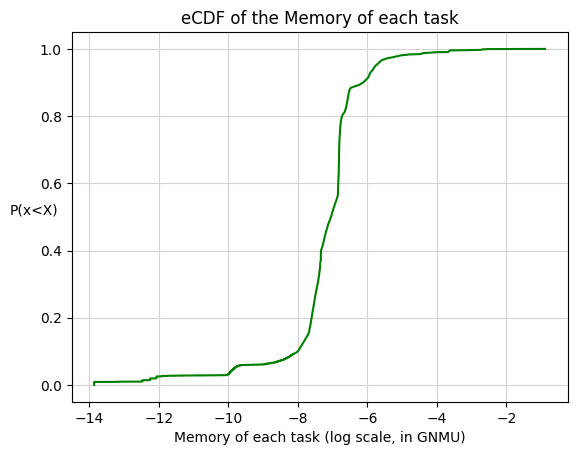

In [5]:
ecdf_Memory = ECDF(data.Memory)
plt.plot(np.log(ecdf_Memory.x), ecdf_Memory.y, color = 'green')
plt.xlabel('Memory of each task (log scale, in GNMU)')
plt.ylabel('P(x<X)',rotation=0)
plt.title('eCDF of the Memory of each task')
plt.grid(which='major', color = 'lightgray')
plt.show()

Again also in this case we find that most of tasks are actually small, with $eCDF(e^{-6}) = 0.91$.

The last quantity that we need to have informations about is the time that passed from the first task up to the last to arrive to the servers.

In [6]:
print(f'{(max(data.Arrival_Time) - min(data.Arrival_Time)) /(60*60*24)} days')

30.999604561354165 days


## Functions

In this section all the function we will need for the analysis will be defined.

### Baseline

The baseline for our analysis is a simple algorithm composed by:

- LWL, for the dispatching. So we'll always assign the task to the server with the least work left

- FCFS, for the scheduling. So, if a task is assigned to a server, the task will have to wait for all tasks that where present in the server before it to be completed before starting it's evaluation.

This combination makes the algorithm fairly easy to implement: when a task with $X = x_n$ is assigned to a server with unfinished work $U = U_k$ then the task's system time will be $S = U_k + x_n$.

In [10]:
# Function to compute the results for our baseline dispatching + scheduling algorithm
def Baseline(servers, task, time):

    # Take out the time passed from each server
    for server in servers.keys():
        servers[server] = max([0, servers[server] - time])

    # Select the server with less work left to do
    selected_server = min([server for  server in servers.items()], key = lambda x: x[1])[0]
    # Add the time needed to compute the task just assigned
    servers[selected_server] += task['X']

    # Return the result of the task
    return (task,  servers[selected_server], selected_server)


### Personal Algorithm

For our algorithm, instead, we chose to use:

- Our own version of the JBTg-d, for the dispatching. Where we will set a threshold but, instead that setting it on the queue length, our threshold is going to be based on the Unfinished work accross all servers.
- SRPT, for the scheduling. So each server will execute first the task that requires less time to be completed, even if it means that the server will have to stop an already started task to compute another one.

In [2]:
def server_iteration(server, prev_time, time):
    # To store the information of the tasks that ended during the time interval
    completed = []

    # To count the passing time
    time_in_server = 0
    
    # Extract the server informations
    server_id = server[0]
    server_content = server[1]

    # In this case the server was not computing any task
    if(server_content['current_task'] == None and len(server_content['queue']) == 0):
        return completed
    

    if(server_content['current_task'] != None):
        # Extract the task that the server was computing
        task = server_content['current_task']
        server_content['current_task'] = None

        # while there are tasks that finished during the time interval
        while(task['X'] - time + time_in_server <= 0 and task['Arrival_Time'] <= prev_time):

            # Store the informations of the completed task: (task, time to complete it, server that did the task)
            completed.append((task, prev_time + task['X'] + time_in_server - task['Arrival_Time'], server_id))
            
            # sum to the time spent in server during the iteration the time used to finish the task
            time_in_server += task['X']
            task = None

            possible_next_task = [x for x in server_content['queue'] if x['Arrival_Time'] <= prev_time]
            # If there is some task in the queue
            if(len(possible_next_task)):
                # Select the server that was initiated after 
                task = min(possible_next_task, key = lambda x: x['X'])
                # And remove it from the queue
                server_content['queue'].remove(task)
            else:
                break
    # The server wasn't working on anything, but it has something in queue
    else:
        # Select the server that was initiated after 
        task = min([x for x in server_content['queue']], key = lambda x: x['X'])
        # And remove it from the queue
        server_content['queue'].remove(task)
    
    # If there is a task in the server that was started (but didn't end) or has been put in queue during the time interval
    if(task):
        # And the task hasn't just arrived
        if(task['Arrival_Time'] <= prev_time):
        # Take out the amount of work done 
            task['X'] -= (time - time_in_server)
        
        # Set the task as current task
        server_content['current_task'] = task
        # Take out of the Unfinished work the amount of work done
        server_content['Unfinished_work'] -= time_in_server
    
    else:
        server_content['Unfinished_work'] = 0

    # Return the informations about the completed tasks
    return completed


# Function to check if any of the servers passed the threshold
def Update_dispatcher_list(servers, dispatcher_list):

    # to count the msgs that will be sent from the servers to the dispatcher
    L_update = 0 

    # For each of the servers
    for i, server in servers.items():
        # If the server goes from busy to idle
        if(server['Unfinished_work'] <= server['Threshold'] and dispatcher_list[i-1] == 0):
            # Send the msg and change the list to 1
            L_update +=1 
            dispatcher_list[i-1] = 1

        # If the server goes from idle to busy
        if(server['Unfinished_work'] > server['Threshold'] and dispatcher_list[i-1] == 1):
            # Send the msg and change the list to 0
            L_update +=1 
            dispatcher_list[i-1] = 0
    
    # Give back how many msg were sent and the new server status
    return L_update, dispatcher_list

# Shortest Remaining Processing Time (SRPT)
def Scheduling(new_time, prev_time, servers, dispatcher_list):
    # How much time has passed
    time = new_time - prev_time
    # To store the possible completed tasks 
    completed = []
    # Iterating over the servers
    for server in servers.items():
        # Compute the server iteration
        completed_in_server = server_iteration(server, prev_time, time)
        # Store the tasks completed during the server iteration
        completed = completed + completed_in_server
        
    # Check if any of the servers passed the threshold
    L, dispatcher_list = Update_dispatcher_list(servers, dispatcher_list)

    # Return the infromation of the finished tasks, the number of msg sent and the servers status
    return completed, L, dispatcher_list


In [4]:
def Dispatching(servers, task, dispatcher_list, time, check, task_assigned):
    # To store the number of msg exchanged
    L_dispatching = 0 

    # If we have to recompute the threshold (timeout or all servers busy)
    if(check or np.sum(dispatcher_list) == 0):

        # If there is heavy traffic, so if (number of task assigned)/(len of the time interval) over 1 or if all the server are 'busy'
        if(task_assigned['count']/(intervals[task_assigned['interval_idx']]-intervals[task_assigned['interval_idx']-1]) > 1 or np.sum(dispatcher_list) == 0):
            # We take a less conservative threshold
            threshold = np.quantile(q = 0.5, a = [server['Unfinished_work'] for server in servers.values()])
        # If the threshold is recomputed just for the time out
        else:
            # We take a more conservative threshold
            threshold = np.quantile(q = 0.25, a = [server['Unfinished_work'] for server in servers.values()])
        
        # Index of the 'new' idle servers
        idx = [i - 1  for i, server in servers.items() if server['Unfinished_work'] <= threshold]
        
        # new dispatcher list
        dispatcher_list = np.zeros(64) 
        dispatcher_list[idx] = 1
        
        # Set the new threshold
        for server in servers.values():
            server['Threshold'] = threshold
        
        # When we have to compute the threshold we will need to send 64 msg to know the Unfinished_works
        L_dispatching += 64*2

    # Select the idle servers
    possible_servers = np.where(dispatcher_list == 1)[0] + 1
    # And choose one randomly
    selected_server = np.random.choice(possible_servers)

    # Add new task to server
    servers[selected_server]['queue'].append(task)
    servers[selected_server]['Unfinished_work'] += task['X']

    return  dispatcher_list, L_dispatching

### General functions

In [7]:
# Since we are iterating over the rows of the dataframe, the loop will end just after assigning the last task, so
# We need this function in order to complete the tasks that are not yet done at the arrival of the last task
def empty_servers(servers):    
    # To store the time the last server finishes 
    final_time = 0
    # To store the last results
    completed = []

    # For each of the servers
    for i, server in servers.items():
        last_time = data.at[len(test_data)-1,'Arrival_Time']
        # If there are still tasks to do
        while(server['current_task']!=None):
            # Save how much time it needs to be ended
            last_time += server['current_task']['X']

            # Compute how much time it was in the server
            time_in_server = last_time - server['current_task']['Arrival_Time']

            # Append the result
            completed.append((server['current_task'], time_in_server, i))
            server['current_task']=None

            # If there is still something in queue
            if(len(server['queue']) != 0):
                # Select the new current task as the one with less remaining time
                server['current_task'] = min([x for x in server['queue']], key = lambda x: x['X'])
                # And remove from the queue the new current task
                server['queue'].remove(server['current_task'])
        
        # Get the maximum of times the servers finish
        final_time = max([last_time, final_time])

    # Ruturn the time and the last results
    return final_time, completed


# Final function that given the results will give retur the metric evaluations
def compute_evaluations(results, data, time):
    # Find all the jobs_id
    Jobs = list(data.Job_ID)
    # And their arrival times
    Starting_times = list(data.Arrival_Time)

    # Create the dictionary with entries for each (unique) job
    RT = {}

    # Initialize the dictionary for each job
    for J, S in zip(Jobs, Starting_times):
        if J not in RT.keys():
            RT[J] = {'Start': S, 'End': 0}

    # Compute the metrics     
    for result in results:
        task = result[0]
        final_time = result[1] + task['Arrival_Time'] 

        # Finish time
        RT[task['Job_ID']]['End'] = max([RT[task['Job_ID']]['End'], final_time])
        # Response time
        RT[task['Job_ID']]['RT'] = RT[task['Job_ID']]['End']- RT[task['Job_ID']]['Start']
        # Service time
        if('Service_time' not in RT[task['Job_ID']].keys()):
            RT[task['Job_ID']]['Service_time'] = task['X']
        else:
            RT[task['Job_ID']]['Service_time'] += task['X']
        # Slowdown
        if(RT[task['Job_ID']]['Service_time'] == 0):
            RT[task['Job_ID']]['Slow_down'] = 1
            continue
        RT[task['Job_ID']]['Slow_down'] = RT[task['Job_ID']]['RT']/RT[task['Job_ID']]['Service_time']

    # Store all the informations in a data frame
    Q = pd.DataFrame(RT)
    Q = Q.T

    # Utilization coefficients
    rho = np.zeros(64)
    
    for result in results:
        rho[result[-1] - 1] += data.iloc[result[0]['index']]['X']

    rho = rho/(time - data.iat[0,2])

    # Return everything
    return Q, rho

## Execute the algorithms

### Baseline

In [11]:
data = pd.read_csv('./Data/Cell_a.csv')
# Arrival time from microseconds to seconds
data['Arrival_Time'] = data.Arrival_Time.apply(lambda x: x/1_000_000)
# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
# Get only the data that has CPU different from 0
data = data[data.CPU != 0]
servers = dict([(i+1, 0) for i in range(64)])

In [12]:
results_base = []
L = []
prev_time = data.iloc[0].Arrival_Time
final_time = 0

# For each task
for task in tqdm(range(len(data))):
    # Extract the task informations
    new_task = dict(data.iloc[task])
    new_task['index'] = task
    new_time = new_task['Arrival_Time']

    # Call the baseline algorithm
    result = Baseline(servers, new_task, new_time - prev_time)
    # Store the result
    results_base.append(result)
    
    prev_time = new_time
    # Keep track of the final time
    final_time = max([final_time, result[1] + new_time])


100%|██████████| 2282872/2282872 [03:23<00:00, 11232.66it/s]


Show the metric evaluations

In [31]:
Q_base, rho_base = compute_evaluations(results_base, data, final_time)
L_base = np.sum([64*2 for _ in range(len(data))])
print(f'Our metric evaluations for the algorithm are: \n - Mean Reponse time: {round(np.mean(list(Q_base.RT)),2)} s', 
    f'\n - Mean Job Slowdown: {round(np.mean(list(Q_base.Slow_down)),2)} \n - Mean messaging load: {round(L_base/len(data),2)}',
    f'\n - Mean utilization coefficient: {round(np.mean(rho_base),2)}')

Our metric evaluations for the algorithm are: 
 - Mean Reponse time: 27603.9 s 
 - Mean Job Slowdown: 1241675.57 
 - Mean messaging load: 128.0 
 - Mean utilization coefficient: 0.54


In [28]:
np.round(rho_base, 2)

array([0.9 , 0.82, 0.81, 0.79, 0.77, 0.74, 0.78, 0.76, 0.76, 0.73, 0.71,
       0.7 , 0.64, 0.61, 0.63, 0.64, 0.6 , 0.58, 0.57, 0.57, 0.58, 0.57,
       0.58, 0.54, 0.53, 0.55, 0.52, 0.51, 0.52, 0.5 , 0.48, 0.46, 0.5 ,
       0.48, 0.47, 0.46, 0.45, 0.48, 0.45, 0.44, 0.43, 0.44, 0.42, 0.44,
       0.43, 0.47, 0.49, 0.44, 0.41, 0.41, 0.42, 0.42, 0.39, 0.45, 0.41,
       0.43, 0.45, 0.46, 0.42, 0.46, 0.41, 0.41, 0.39, 0.4 ])

### Personal Algorithm

In [17]:
data = pd.read_csv('./Data/Cell_a.csv')
# Arrival time from microseconds to seconds
data['Arrival_Time'] = data.Arrival_Time.apply(lambda x: x/1_000_000) 

# Actual time needed to compute the task
data['X'] = data.CPU.apply(lambda x: x/0.1)
servers = dict([(i+1, {'queue':[], 'Threshold': 0, 'current_task': None, 'Unfinished_work': 0}) for i in range(64)])
dispatcher_list = np.ones(64)
intervals = np.linspace(603.0263, 2678968.860401, num = 5001)

In [8]:
results = []
L = 0
interval = {'interval_idx': 1, 'count': 0}
check = 0 
prev_time = data.iloc[0].Arrival_Time

# for each task 
for task in tqdm(range(len(data))):

    # Extract the task informations
    new_task = dict(data.iloc[task])
    new_task['index'] = task
    new_time = new_task['Arrival_Time']

    if(new_time <= intervals[interval['interval_idx']]):
        # Count how many tasks arrive in a given time interval
        interval['count'] += 1
    else:
        # At the end of the time interval select the next
        interval = {'interval_idx': interval['interval_idx']+1, 'count': 0}
        # And we want to compute the new threshold
        check = 1
        
    # Call the dispatcher to assign the new task
    dispatcher_list, L_aux = Dispatching(servers, new_task, dispatcher_list, new_time - prev_time, check, interval)
    check = 0

    # Keep track of the number of msg exchanged between servers and dispatcher
    L += L_aux

    # Call the scheduling function to update the servers
    completed, L_aux , dispatcher_list = Scheduling(new_time, prev_time, servers, dispatcher_list)
    
    # Store the results
    if(len(completed)):
        results = results + completed

    # Keep track of the number of msg exchanged between servers and dispatcher
    L += L_aux    
    prev_time = new_time

# Complete any task still present in the servers
final_time, completed = empty_servers(servers)
results = results + completed

 12%|█▏        | 284707/2329133 [02:56<36:15, 939.77it/s]  

In [13]:
with open('results.pkl', 'rb') as f:
    results = pkl.load(f)

In [15]:
with open('final_time_and_L.pkl', 'rb') as f:
    final_time, L = pkl.load(f)

In [37]:
Q, rho = compute_evaluations(results, data, final_time)
print(f'Our metric evaluations for the algorithm are: \n - Mean Reponse time: {round(np.mean(list(Q.RT)),2)} s',
    f'\n - Mean Job Slow: {round(np.mean(list(Q.Slow_down)),2)} \n - Mean messaging load: {round(L/len(data),2)}',
    f'\n - Mean utilization coefficient: {round(np.mean(rho),2)}')

Our metric evaluations for the algorithm are: 
 - Mean Reponse time: 2823.27 s 
 - Mean Job Slowdown: 188248.81 
 - Mean messaging load: 1.41 
 - Mean utilization coefficient: 0.54


In [29]:
np.round(rho, 2)

array([0.57, 0.52, 0.54, 0.51, 0.48, 0.55, 0.52, 0.52, 0.51, 0.57, 0.54,
       0.51, 0.53, 0.54, 0.73, 0.52, 0.5 , 0.49, 0.57, 0.54, 0.51, 0.52,
       0.54, 0.51, 0.5 , 0.51, 0.54, 0.59, 0.51, 0.54, 0.52, 0.55, 0.52,
       0.64, 0.55, 0.52, 0.59, 0.56, 0.51, 0.49, 0.51, 0.53, 0.52, 0.55,
       0.59, 0.56, 0.52, 0.54, 0.5 , 0.64, 0.53, 0.51, 0.56, 0.53, 0.54,
       0.56, 0.54, 0.51, 0.58, 0.56, 0.58, 0.54, 0.5 , 0.51])

## Graphical comparison

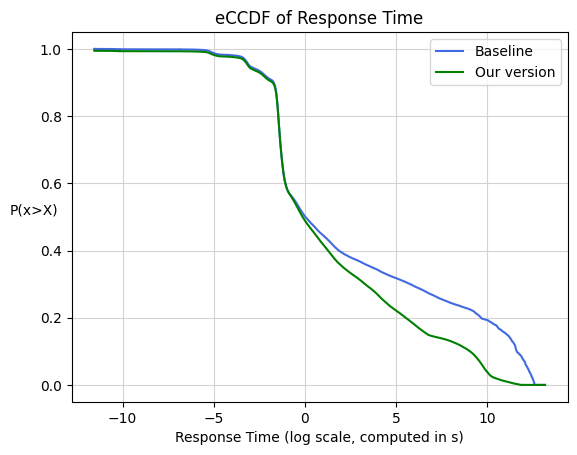

In [48]:
ecdf_RT_base = ECDF(Q_base.RT)
ecdf_RT = ECDF(Q.RT)
plt.plot(np.log(ecdf_RT_base.x),  1- ecdf_RT_base.y, color = 'royalblue')
plt.plot(np.log(ecdf_RT.x),  1- ecdf_RT.y, color = 'green')
plt.legend(['Baseline','Our version'])
plt.xlabel('Response Time (log scale, computed in s)')
plt.ylabel('P(x>X)', rotation = 0)
plt.title('eCCDF of Response Time')
plt.grid(which='major', color = 'lightgray')
plt.show()

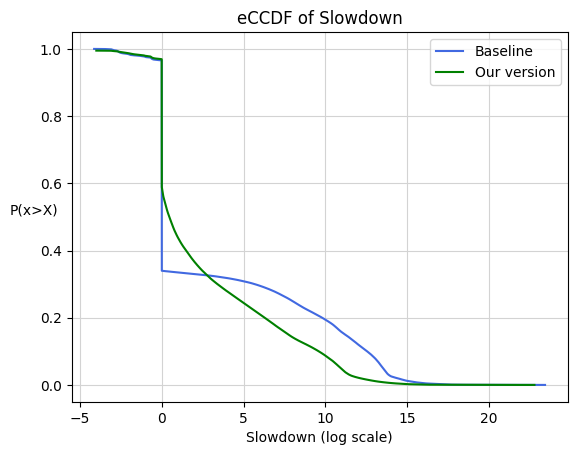

In [49]:
ecdf_Service_time_base = ECDF(Q_base.Slow_down)
ecdf_Service_time = ECDF(Q.Slow_down)
plt.plot(np.log(ecdf_Service_time_base.x),  1- ecdf_Service_time_base.y, color = 'royalblue')
plt.plot(np.log(ecdf_Service_time.x),  1- ecdf_Service_time.y, color = 'green')
plt.legend(['Baseline', 'Our version'])
plt.xlabel('Slowdown (log scale)')
plt.ylabel( 'P(x>X)', rotation = 0)
plt.title('eCCDF of Slowdown')
plt.grid(which='major', color = 'lightgray')
plt.show()

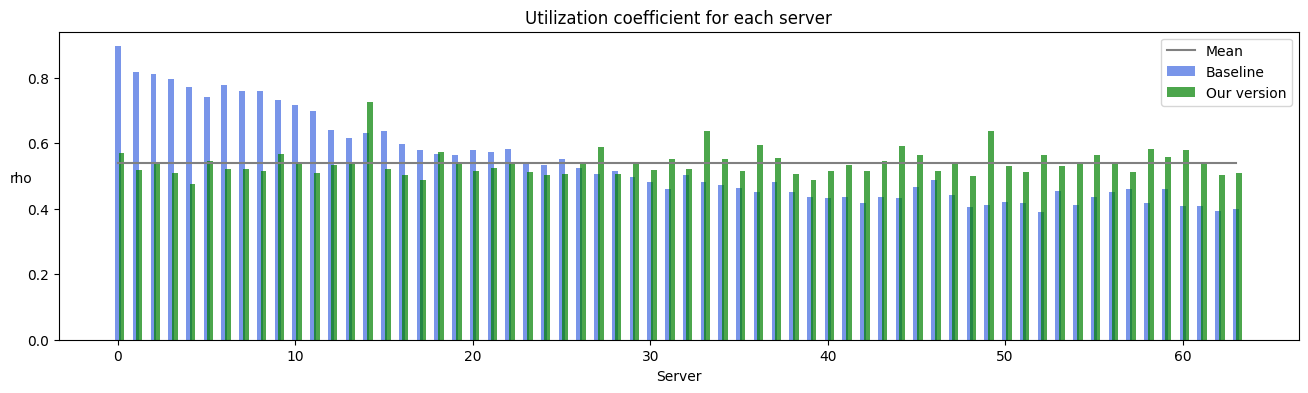

In [53]:
n = len(rho)
x = np.arange(n)

plt.figure(figsize=(16,4))
plt.bar(x, rho_base, width=1/3, facecolor='royalblue', alpha=.7, linewidth=0)
plt.bar(x+0.2, rho, width=1/3, facecolor='green', alpha=.7, linewidth=0)
plt.xlabel('Server')
plt.ylabel('rho', rotation = 0)
plt.plot(x, np.ones(n)*np.mean(rho), color = 'gray')
plt.legend(['Mean','Baseline' , 'Our version'])
plt.title('Utilization coefficient for each server')
plt.show()